In [ ]:
'''
Outputs an (n+1) by (# of frequencies) array
where n is the number of IR Spectra passed in
First row is frequencies, all others are standard
deviations in absorption rates for pairs of molecules
at each corresponding frequency.
Uploaded July 5, 2024 by Bishop
'''

In [5]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

In [6]:
IRSpectra_File = np.load(<PATH>)
'''
print('The file you have loaded in has shape:', IRSpectra_File.shape)
print('There are ', len(IRSpectra_File[0]), 'many frequencies')
'''

The file you have loaded in has shape: (4, 3550)
There are  3550 many frequencies


In [7]:
#Build arrays of Pairs of IR Spectra:
def buildPairwiseIRSpectraArrays(file):
    full_array = np.concatenate((file[0], file[0]))
    for i in range(1, len(file)):
        if i < len(file):
            for j in range(i+1, len(file)):
                full_array = np.vstack((full_array, np.concatenate((file[i], file[j]))))
    return full_array

def buildPairArray(data, pairing):
    return np.vstack((data[0], data[pairing]))

#For a given pairing, create the KDE object
def buildKDE(pairArray):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(pairArray.T)
    return kde

def calculateSD(kde, data):
    # Create frequency, std. deviation array
    # Define the frequency range and absorption range
    #frequency_range = np.arange(min(data[0]), max(data[0]))
    frequency_range = np.linspace(min(data[0]), max(data[0]), round(len(data[0])/2))
    absorption_range = np.linspace(-0.5, 1.5,100)  # You can adjust the number, typically use 100
    #of points in the absorption range with the third parameter
    # Prepare a 2D grid of points
    std_devs = np.zeros(len(frequency_range))
    epsilon = 1e-10  # Prevent divide by zero error
    for i, freq in enumerate(frequency_range):
        # Create an array of points with the current frequency and varying absorption values
        points = np.vstack([np.full(absorption_range.shape, freq), absorption_range]).T
        # Evaluate the KDE at these points
        log_densities = kde.score_samples(points)
        densities = np.exp(log_densities)
        # Ensure densities are not all zeros
        sum_densities = np.sum(densities) + epsilon
        # Calculate the weighted mean and variance
        weighted_mean = np.sum(
            absorption_range * densities) / sum_densities  # We use a weighted mean because each absorption
        # value should only contribute to the average according to its density
        weighted_var = np.sum(densities * (absorption_range - weighted_mean) ** 2) / (sum_densities)
        std_devs[i] = np.sqrt(weighted_var)
    # The result is stored in std_devs, indices correspond to frequencies
    return std_devs
    
#Row 0 will be Frequencies
def buildSDArray(data):
    sdArray = data[0][0:round(len(data[0])/2)]
    for i in range(1, len(data)):
        sdArray = np.vstack((sdArray, calculateSD(buildKDE(buildPairArray(data, i)), data)))
    return sdArray

#For each pairing of molecules, plot frequency vs. standard deviation in absorption rates
def graphSDPlots(sdArray):
    for i in range(1, len(sdArray)):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(sdArray[0], sdArray[i])
        ax.set_title('Standard Deviation in Absorption Rates for Pairing'+str(i))
        ax.set_xlabel('Frequency')
        ax.set_ylabel('SD')
        plt.show()

In [8]:
SD_ARRAY = buildSDArray(buildPairwiseIRSpectraArrays(IRSpectra_File))

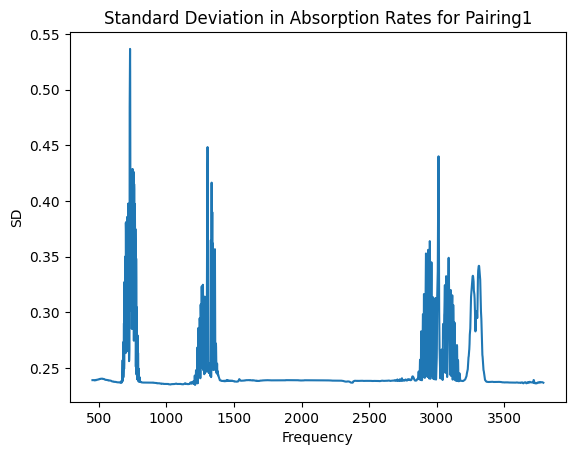

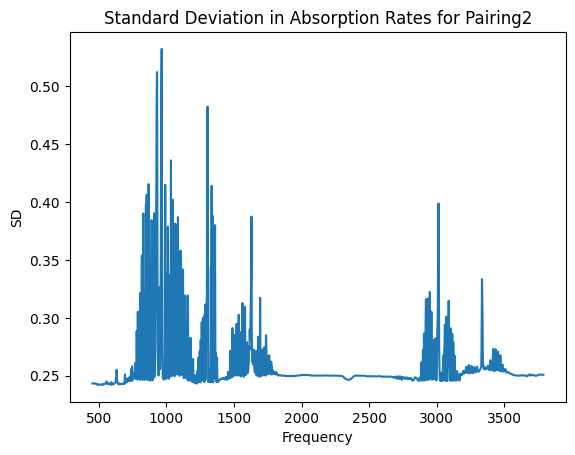

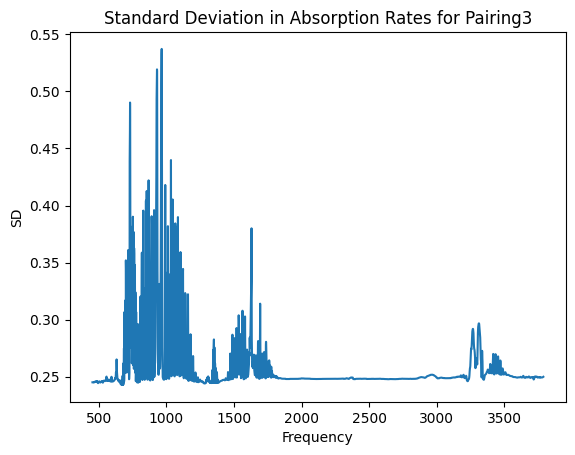

In [9]:
#graphSDPlots(SD_ARRAY)

In [10]:
#np.save(<PATH>, SD_ARRAY)